# Machine Learning Applications to Simulated Blackjack Data

Scott Atkinson

## [0. Contents](#0.)<a id='0.'></a>

## [1. Import libraries](#1.)

## [2. Obtain summary DataFrame](#2.)

## [3. Modeling](#3.)

## 1. Import libraries<a id='1.'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor



import time
import json
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

import warnings
warnings.filterwarnings('ignore')

## 2. Obtain summary DataFrame<a id='2.'></a>

In [2]:
# losses function without plots

def losses(df):
    df.reset_index(drop=True, inplace=True)
    mins = []
    np.random.seed(11)
    start_indexes = np.random.choice(950000, size=100000, replace=False)
    for i in start_indexes:
        sample50k = np.array(df.loc[i:i + 49999, 'accumulated_winnings'])
        if i != 0:
            mins.append(sample50k.min() - df.loc[i-1,'accumulated_winnings'])
        else:
            mins.append(sample50k.min())
    return mins

Produce dataframe with summary stats for non-counter strategies.

In [ ]:
strats = ['naive','cc','basic']
decks = [2,4,6]
pens = [0.5, 1, 1.5, 2]
seventeens = ['S17','H17']
BJpayouts = [[3,2],[6,5]]

product = []
for strat in strats:
    for deck in decks:
        for pen in pens:
            for seventeen in seventeens:
                for BJpay in BJpayouts:
                    if pen == deck:
                        continue
                    else:
                        product.append((strat,deck,pen,BJpay,seventeen))
                    

strat_list = []
deck_list = []
pen_list = []
seventeen_list = []
BJ_pay_list = []
prob_win_list = []
EV_list = []
prob_win_pos_list = []
EV_pos_list = []
fifth_loss_list = []

for params in product:
    strat, deck, pen, BJ_pay, seventeen = params
    strat_list.append(strat)
    deck_list.append(deck)
    pen_list.append(pen)
    seventeen_list.append(seventeen)
    BJ_pay_list.append(BJ_pay)
    read_path = '/media/saa/My Passport/Blackjack/sim_dfs/%s/%s_%s_%s_%s_%s.csv'\
    %(strat,deck,pen,seventeen, BJpay, strat)
    df = pd.read_csv(read_path)
    prob_win_list.append(np.sum(df['total_round_winnings'] >=0)/1000000)
    EV_list.append(np.mean(df['total_round_winnings']))
    prob_win_pos_list.append(np.sum((df['opening_count']>0) & (df['total_round_winnings']>= 0))
                      /np.sum(df['opening_count']>0) )  
    EV_pos_list.append(np.mean(df[df['opening_count']>0]['total_round_winnings']))
    fifth_loss_list.append(np.percentile(losses(df),[0,5])[1])
    


dic = {'strategy':strat_list, 'decks':deck_list,\
       'penetration':pen_list, 'seventeen':seventeen_list,\
       'BJ_payout':BJ_pay_list, 'probability_of_winning':prob_win_list,\
       'expected_value':EV_list, 'prob_of_winning_on_pos_count':prob_win_pos_list,\
       'expected_value_on_pos_count':EV_pos_list, 'fifth_percentile_loss':fifth_loss_list}
out = pd.DataFrame(dic)
out.to_csv('summary_dfs/noncounters.csv')

In [3]:
noncounters = pd.read_csv('summary_dfs/noncounters.csv')

Append count bet and spot columns to eventually align with counters summary DataFrame.

In [4]:
for count in range(-1,7):
    noncounters['%s_count_bet'%(count)] = 1
    noncounters['%s_count_spot'%(count)] = 1

In [5]:
noncounters = noncounters.drop('Unnamed: 0', axis = 1)
noncounters.columns

Index(['strategy', 'decks', 'penetration', 'seventeen', 'BJ_payout',
       '-1_count_bet', '-1_count_spot', '0_count_bet', '0_count_spot',
       '1_count_bet', '1_count_spot', '2_count_bet', '2_count_spot',
       '3_count_bet', '3_count_spot', '4_count_bet', '4_count_spot',
       '5_count_bet', '5_count_spot', '6_count_bet', '6_count_spot',
       'probability_of_winning', 'expected_value',
       'prob_of_winning_on_pos_count', 'expected_value_on_pos_count',
       'fifth_percentile_loss'],
      dtype='object')

In [6]:
cols = ['strategy', 'decks', 'penetration', 'seventeen', 'BJ_payout', '-1_count_bet', '-1_count_spot', '0_count_bet',
       '0_count_spot', '1_count_bet', '1_count_spot', '2_count_bet',
       '2_count_spot', '3_count_bet', '3_count_spot', '4_count_bet',
       '4_count_spot', '5_count_bet', '5_count_spot', '6_count_bet',
       '6_count_spot',
       'probability_of_winning', 'expected_value',
       'prob_of_winning_on_pos_count', 'expected_value_on_pos_count',
       'fifth_percentile_loss']

noncounters = noncounters[cols]

In [7]:
noncounters.to_csv('summary_dfs/noncounters.csv')

Now for the counters:

In [8]:
# generate product list of parameters (again)

decks = [2,4,6]
pens = [0.5, 1, 1.5, 2]
seventeens = ['S17','H17']
BJpayouts = [[3,2],[6,5]]

product = []
for deck in decks:
    for pen in pens:
        for seventeen in seventeens:
            for BJpays in BJpayouts:
                if pen == deck:
                    continue
                else:
                    product.append((deck,pen,seventeen,BJpays))

Form spreads dictionary

In [9]:
# function to replace the second entry in a list to a 1
def to_one(ls):
    new = [i for i in ls]
    new[1] = 1
    return new

def dict_one(dic):
    return {key:to_one(dic[key]) for key in list(dic.keys())}
    

In [10]:
# spreads dictionary

spreads = {}

spreads['twelve'] = {-1:[1,1], 0:[1,1], 1:[1,2], 2:[4,2], 3:[6,2], 4:[8,2], 5:[10,2], 6:[12,2]}
spreads['twelve_1'] = dict_one(spreads['twelve'])

spreads['twenty_a'] = {-1:[1,1], 0:[1,1], 1:[2,2], 2:[6,2], 3:[10,2], 4:[13,2], 5:[17,2], 6:[20,2]}
spreads['twenty_a_1'] = dict_one(spreads['twenty_a'])

spreads['six'] = {-1:[1,1], 0:[1,1], 1:[1,2], 2:[2,1], 3:[3,2], 4:[4,2], 5:[5,2], 6:[6,2]}
spreads['six_1'] = dict_one(spreads['six'])

spreads['fifty'] = {-1:[1,1], 0:[1,1], 1:[5,1], 2:[10,1], 3:[20,2], 4:[30,2], 5:[40,2], 6:[50,2]}
spreads['fifty_1'] = dict_one(spreads['fifty'])

spreads['eight'] = {-1:[1,1], 0:[1,1], 1:[1,1], 2:[2,1], 3:[3,1], 4:[5,2], 5:[6,2], 6:[8,2]}
spreads['eight_1'] = dict_one(spreads['eight'])

spreads['eighteen'] = {-1:[1,1], 0:[1,1], 1:[3,2], 2:[6,2], 3:[9,2], 4:[12,2], 5:[15,2], 6:[18,2]}
spreads['eighteen_1'] = dict_one(spreads['eighteen'])

spreads['twenty-four'] = {-1:[1,1], 0:[1,1], 1:[4,1], 2:[8,1], 3:[14,1], 4:[16,2], 5:[18,2], 6:[24,2]}
spreads['twenty-four_1'] = dict_one(spreads['twenty-four'])

spreads['twenty_b'] = {-1:[1,1], 0:[1,1], 1:[3,2], 2:[6,2], 3:[9,2], 4:[12,2], 5:[15,2], 6:[20,2]}
spreads['twenty_b_1'] = dict_one(spreads['twenty_b'])

spreads['thirty'] = {-1:[1,1], 0:[1,1], 1:[5,1], 2:[10,1], 3:[15,1], 4:[20,2], 5:[25,2], 6:[30,2]}
spreads['thirty_1'] = dict_one(spreads['thirty'])

spreads['sixteen'] = {-1:[1,1], 0:[1,1], 1:[1,1], 2:[4,1], 3:[7,1], 4:[10,1], 5:[12,2], 6:[16,2]}
spreads['sixteen_1'] = dict_one(spreads['sixteen'])

Produce summary DataFrame from counter samples

In [12]:
strat_list = []
deck_list = []
pen_list = []
seventeen_list = []
BJ_pay_list = []
prob_win_list = []
EV_list = []
prob_win_pos_list = []
EV_pos_list = []
fifth_loss_list = []

strat = 'counter'

minus_one_count_bet_list = []
minus_one_count_spot_list = []

zero_count_bet_list = []
zero_count_spot_list = []

one_count_bet_list = []
one_count_spot_list = []

two_count_bet_list = []
two_count_spot_list = []

three_count_bet_list = []
three_count_spot_list = []

four_count_bet_list = []
four_count_spot_list = []

five_count_bet_list = []
five_count_spot_list = []

six_count_bet_list = []
six_count_spot_list = []

for spread_name in list(spreads.keys()):
    for params in product:
        start = time.time()
        deck, pen, seventeen, BJ_pays = params
        strat_list.append(strat)
        deck_list.append(deck)
        pen_list.append(pen)
        seventeen_list.append(seventeen)
        BJ_pay_list.append(BJ_pays)
        read_path = '/media/saa/My Passport/Blackjack/sim_dfs/%s/%s/%s_%s_%s_%s_%s.csv'\
        %(strat,spread_name,deck,pen,seventeen, BJpays, spread_name)
        df = pd.read_csv(read_path)
        prob_win_list.append(np.sum(df['total_round_winnings'] >=0)/1000000)
        EV_list.append(np.mean(df['total_round_winnings']))
        prob_win_pos_list.append(np.sum((df['opening_count']>0) & (df['total_round_winnings']>= 0))
                          /np.sum(df['opening_count']>0) )  
        EV_pos_list.append(np.mean(df[df['opening_count']>0]['total_round_winnings']))
        fifth_loss_list.append(np.percentile(losses(df),[0,5])[1])
        
        minus_one_count_bet_list.append(spreads[spread_name][-1][0])
        minus_one_count_spot_list.append(spreads[spread_name][-1][1])

        zero_count_bet_list.append(spreads[spread_name][0][0])
        zero_count_spot_list.append(spreads[spread_name][0][1])

        one_count_bet_list.append(spreads[spread_name][1][0])
        one_count_spot_list.append(spreads[spread_name][1][1])

        two_count_bet_list.append(spreads[spread_name][2][0])
        two_count_spot_list.append(spreads[spread_name][2][1])

        three_count_bet_list.append(spreads[spread_name][3][0])
        three_count_spot_list.append(spreads[spread_name][3][1])

        four_count_bet_list.append(spreads[spread_name][4][0])
        four_count_spot_list.append(spreads[spread_name][4][1])

        five_count_bet_list.append(spreads[spread_name][5][0])
        five_count_spot_list.append(spreads[spread_name][5][1])

        six_count_bet_list.append(spreads[spread_name][6][0])
        six_count_spot_list.append(spreads[spread_name][6][1])
        end = time.time()
        
        print('%s %s %s %s %s done'%(deck,pen,seventeen,BJpays,spread_name))
        print('time elapsed: ', end-start)
        
dic = {'strategy':strat_list,\
       'decks':deck_list,\
       'penetration':pen_list,\
       'seventeen':seventeen_list,\
       'BJ_payout':BJ_pay_list,\
       '-1_count_bet':minus_one_count_bet_list,\
       '-1_count_spot':minus_one_count_spot_list,\
       '0_count_bet':zero_count_bet_list,\
       '0_count_spot':zero_count_spot_list,\
       '1_count_bet':one_count_bet_list,\
       '1_count_spot':one_count_spot_list,\
       '2_count_bet':two_count_bet_list,\
       '2_count_spot':two_count_spot_list,\
       '3_count_bet':three_count_bet_list,\
       '3_count_spot':three_count_spot_list,\
       '4_count_bet':four_count_bet_list,\
       '4_count_spot':four_count_spot_list,\
       '5_count_bet':five_count_bet_list,\
       '5_count_spot':five_count_spot_list,\
       '6_count_bet':six_count_bet_list,\
       '6_count_spot':six_count_spot_list,\
       'probability_of_winning':prob_win_list,\
       'expected_value':EV_list,\
       'prob_of_winning_on_pos_count':prob_win_pos_list,\
       'expected_value_on_pos_count':EV_pos_list,\
       'fifth_percentile_loss':fifth_loss_list}
out = pd.DataFrame(dic)
out.to_csv('summary_dfs/counters.csv')

2 0.5 S17 [6, 5] twelve done
time elapsed:  229.6530954837799
2 0.5 S17 [6, 5] twelve done
time elapsed:  227.7769799232483
2 0.5 H17 [6, 5] twelve done
time elapsed:  230.06111764907837
2 0.5 H17 [6, 5] twelve done
time elapsed:  227.24562644958496
2 1 S17 [6, 5] twelve done
time elapsed:  227.74762988090515
2 1 S17 [6, 5] twelve done
time elapsed:  226.57903814315796
2 1 H17 [6, 5] twelve done
time elapsed:  228.48833060264587
2 1 H17 [6, 5] twelve done
time elapsed:  227.96704292297363
2 1.5 S17 [6, 5] twelve done
time elapsed:  231.64517545700073
2 1.5 S17 [6, 5] twelve done
time elapsed:  226.8670792579651
2 1.5 H17 [6, 5] twelve done
time elapsed:  228.4336757659912
2 1.5 H17 [6, 5] twelve done
time elapsed:  226.4243404865265
4 0.5 S17 [6, 5] twelve done
time elapsed:  228.1327464580536
4 0.5 S17 [6, 5] twelve done
time elapsed:  225.60616064071655
4 0.5 H17 [6, 5] twelve done
time elapsed:  228.0165617465973
4 0.5 H17 [6, 5] twelve done
time elapsed:  227.91232562065125
4 1 S17

6 2 H17 [6, 5] twenty_a done
time elapsed:  229.86698174476624
6 2 H17 [6, 5] twenty_a done
time elapsed:  229.76615738868713
2 0.5 S17 [6, 5] twenty_a_1 done
time elapsed:  229.82742619514465
2 0.5 S17 [6, 5] twenty_a_1 done
time elapsed:  226.06851482391357
2 0.5 H17 [6, 5] twenty_a_1 done
time elapsed:  232.05100345611572
2 0.5 H17 [6, 5] twenty_a_1 done
time elapsed:  226.3081021308899
2 1 S17 [6, 5] twenty_a_1 done
time elapsed:  231.38750052452087
2 1 S17 [6, 5] twenty_a_1 done
time elapsed:  226.34051132202148
2 1 H17 [6, 5] twenty_a_1 done
time elapsed:  230.15320920944214
2 1 H17 [6, 5] twenty_a_1 done
time elapsed:  225.6591818332672
2 1.5 S17 [6, 5] twenty_a_1 done
time elapsed:  229.0490095615387
2 1.5 S17 [6, 5] twenty_a_1 done
time elapsed:  226.57257199287415
2 1.5 H17 [6, 5] twenty_a_1 done
time elapsed:  229.44057989120483
2 1.5 H17 [6, 5] twenty_a_1 done
time elapsed:  226.1769368648529
4 0.5 S17 [6, 5] twenty_a_1 done
time elapsed:  229.74823093414307
4 0.5 S17 [6, 5

6 2 H17 [6, 5] six_1 done
time elapsed:  227.3943054676056
2 0.5 S17 [6, 5] fifty done
time elapsed:  229.52906847000122
2 0.5 S17 [6, 5] fifty done
time elapsed:  227.40204787254333
2 0.5 H17 [6, 5] fifty done
time elapsed:  229.0836181640625
2 0.5 H17 [6, 5] fifty done
time elapsed:  227.39215755462646
2 1 S17 [6, 5] fifty done
time elapsed:  229.0507264137268
2 1 S17 [6, 5] fifty done
time elapsed:  228.04791808128357
2 1 H17 [6, 5] fifty done
time elapsed:  230.92786169052124
2 1 H17 [6, 5] fifty done
time elapsed:  226.6893892288208
2 1.5 S17 [6, 5] fifty done
time elapsed:  231.07345819473267
2 1.5 S17 [6, 5] fifty done
time elapsed:  225.74802231788635
2 1.5 H17 [6, 5] fifty done
time elapsed:  229.72372317314148
2 1.5 H17 [6, 5] fifty done
time elapsed:  225.88677048683167
4 0.5 S17 [6, 5] fifty done
time elapsed:  230.45583963394165
4 0.5 S17 [6, 5] fifty done
time elapsed:  225.84039449691772
4 0.5 H17 [6, 5] fifty done
time elapsed:  228.5020260810852
4 0.5 H17 [6, 5] fifty 

2 0.5 S17 [6, 5] eight_1 done
time elapsed:  226.3735830783844
2 0.5 H17 [6, 5] eight_1 done
time elapsed:  229.19386196136475
2 0.5 H17 [6, 5] eight_1 done
time elapsed:  226.75585079193115
2 1 S17 [6, 5] eight_1 done
time elapsed:  229.49490332603455
2 1 S17 [6, 5] eight_1 done
time elapsed:  227.1639106273651
2 1 H17 [6, 5] eight_1 done
time elapsed:  228.05226826667786
2 1 H17 [6, 5] eight_1 done
time elapsed:  226.45406675338745
2 1.5 S17 [6, 5] eight_1 done
time elapsed:  229.31177759170532
2 1.5 S17 [6, 5] eight_1 done
time elapsed:  226.29055953025818
2 1.5 H17 [6, 5] eight_1 done
time elapsed:  229.18452739715576
2 1.5 H17 [6, 5] eight_1 done
time elapsed:  225.73606252670288
4 0.5 S17 [6, 5] eight_1 done
time elapsed:  229.0420527458191
4 0.5 S17 [6, 5] eight_1 done
time elapsed:  225.88590669631958
4 0.5 H17 [6, 5] eight_1 done
time elapsed:  227.68625044822693
4 0.5 H17 [6, 5] eight_1 done
time elapsed:  226.46939420700073
4 1 S17 [6, 5] eight_1 done
time elapsed:  227.9484

6 2 S17 [6, 5] eighteen_1 done
time elapsed:  227.05813479423523
6 2 H17 [6, 5] eighteen_1 done
time elapsed:  228.76584696769714
6 2 H17 [6, 5] eighteen_1 done
time elapsed:  229.17796063423157
2 0.5 S17 [6, 5] twenty-four done
time elapsed:  227.55110478401184
2 0.5 S17 [6, 5] twenty-four done
time elapsed:  227.40288186073303
2 0.5 H17 [6, 5] twenty-four done
time elapsed:  228.41125464439392
2 0.5 H17 [6, 5] twenty-four done
time elapsed:  226.82732701301575
2 1 S17 [6, 5] twenty-four done
time elapsed:  231.24080348014832
2 1 S17 [6, 5] twenty-four done
time elapsed:  226.88058280944824
2 1 H17 [6, 5] twenty-four done
time elapsed:  228.4596073627472
2 1 H17 [6, 5] twenty-four done
time elapsed:  226.92805552482605
2 1.5 S17 [6, 5] twenty-four done
time elapsed:  227.2239317893982
2 1.5 S17 [6, 5] twenty-four done
time elapsed:  226.90881204605103
2 1.5 H17 [6, 5] twenty-four done
time elapsed:  228.805650472641
2 1.5 H17 [6, 5] twenty-four done
time elapsed:  226.47978568077087
4

6 1 S17 [6, 5] twenty_b done
time elapsed:  229.16088271141052
6 1 S17 [6, 5] twenty_b done
time elapsed:  227.65074563026428
6 1 H17 [6, 5] twenty_b done
time elapsed:  229.54164624214172
6 1 H17 [6, 5] twenty_b done
time elapsed:  226.80515313148499
6 1.5 S17 [6, 5] twenty_b done
time elapsed:  228.20363998413086
6 1.5 S17 [6, 5] twenty_b done
time elapsed:  227.29461693763733
6 1.5 H17 [6, 5] twenty_b done
time elapsed:  229.94841623306274
6 1.5 H17 [6, 5] twenty_b done
time elapsed:  227.202552318573
6 2 S17 [6, 5] twenty_b done
time elapsed:  229.02513694763184
6 2 S17 [6, 5] twenty_b done
time elapsed:  227.61847186088562
6 2 H17 [6, 5] twenty_b done
time elapsed:  228.27818727493286
6 2 H17 [6, 5] twenty_b done
time elapsed:  226.41945433616638
2 0.5 S17 [6, 5] twenty_b_1 done
time elapsed:  227.12392568588257
2 0.5 S17 [6, 5] twenty_b_1 done
time elapsed:  227.39868092536926
2 0.5 H17 [6, 5] twenty_b_1 done
time elapsed:  227.4369661808014
2 0.5 H17 [6, 5] twenty_b_1 done
time 

6 0.5 S17 [6, 5] thirty_1 done
time elapsed:  226.2298243045807
6 0.5 H17 [6, 5] thirty_1 done
time elapsed:  227.64880847930908
6 0.5 H17 [6, 5] thirty_1 done
time elapsed:  227.49274945259094
6 1 S17 [6, 5] thirty_1 done
time elapsed:  227.0708830356598
6 1 S17 [6, 5] thirty_1 done
time elapsed:  226.58887219429016
6 1 H17 [6, 5] thirty_1 done
time elapsed:  228.26103019714355
6 1 H17 [6, 5] thirty_1 done
time elapsed:  226.72673058509827
6 1.5 S17 [6, 5] thirty_1 done
time elapsed:  229.2489902973175
6 1.5 S17 [6, 5] thirty_1 done
time elapsed:  226.59267616271973
6 1.5 H17 [6, 5] thirty_1 done
time elapsed:  229.18543195724487
6 1.5 H17 [6, 5] thirty_1 done
time elapsed:  226.7112979888916
6 2 S17 [6, 5] thirty_1 done
time elapsed:  226.89534497261047
6 2 S17 [6, 5] thirty_1 done
time elapsed:  226.22310543060303
6 2 H17 [6, 5] thirty_1 done
time elapsed:  228.11086344718933
6 2 H17 [6, 5] thirty_1 done
time elapsed:  226.91077709197998
2 0.5 S17 [6, 5] sixteen done
time elapsed:  

## 3. Modeling<a id='3.'></a>

Train a model to predict expected value, min losses given a certain game and bet spread. To be completed once all samples are simulated.

In [2]:
df = pd.read_csv('summary_dfs/counters.csv')
df = df.drop(['Unnamed: 0','strategy'], axis=1)
df = pd.get_dummies(df)
df = df.drop(['seventeen_S17','BJ_payout_[6, 5]'], axis=1)

In [3]:
X = df.drop(['probability_of_winning','expected_value','prob_of_winning_on_pos_count','expected_value_on_pos_count','fifth_percentile_loss'],axis=1)
EV = df['expected_value']
losses = df['fifth_percentile_loss']

itrain, itest = train_test_split(range(df.shape[0]), test_size = 0.25, random_state=2)

mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itrain] = True


X_train, X_test, EV_train, EV_test, losses_train, losses_test = X[mask], X[~mask], EV[mask], EV[~mask], losses[mask], losses[~mask]


## Predicting expected value

Time elapsed:  48.3774311542511
-3.022039292501467e+16
R^2:  0.9773879163275925


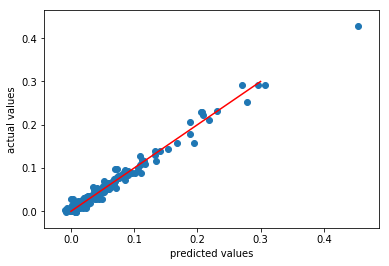

In [5]:
start = time.time()

steps = [('poly',PolynomialFeatures()), ('lr', LinearRegression())]

degrees = [1,2,3,4]

polyreg_params = {'poly__degree':degrees}

polyreg_pipe = Pipeline(steps)

polyreg_EV_cv = GridSearchCV(polyreg_pipe, param_grid=polyreg_params, cv=3)

polyreg_EV_cv.fit(X_train,EV_train)

end = time.time()



print('Time elapsed: ', end-start)

polyreg_EV_df = pd.DataFrame(polyreg_EV_cv.cv_results_)
polyreg_EV_df.to_csv('BJ_regression/polyreg_EV_cv_results.csv')
print(polyreg_EV_cv.best_score_)

polyreg_EV = polyreg_EV_cv.best_estimator_
polyreg_EV.fit(X_train,EV_train)
EV_pred = polyreg_EV.predict(X_test)
print('R^2: ', r2_score(EV_test,EV_pred))

plt.scatter(EV_pred, EV_test)
plt.plot([0,0.3],[0,0.3], c='r')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

Time elapsed:  4586.268975734711
0.91556213924343
R^2:  0.9915859862213448


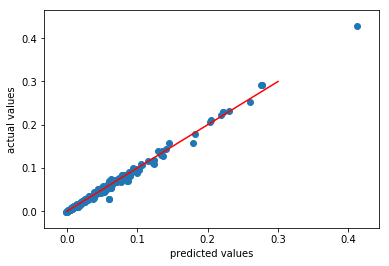

In [6]:
# gridsearch EV with RandomForest


start = time.time()

steps = [('RF', RandomForestRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1,stop=3, num=10)]

criteria = ['mse', 'mae']

depths = [int(n) for n in np.logspace(start=1, stop=2, num=10)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,
            'RF__criterion': criteria,
            'RF__max_depth': depths,
            'RF__max_features': num_features
            }

RF_pipe = Pipeline(steps)

RF_EV_cv = GridSearchCV(RF_pipe, param_grid=RF_params, cv=3)

RF_EV_cv.fit(X_train,EV_train)

end = time.time()



print('Time elapsed: ', end-start)

RF_EV_df = pd.DataFrame(RF_EV_cv.cv_results_)
RF_EV_df.to_csv('BJ_regression/RF_EV_cv_results.csv')
print(RF_EV_cv.best_score_)

RF_EV = RF_EV_cv.best_estimator_
RF_EV.fit(X_train,EV_train)
EV_pred = RF_EV.predict(X_test)
print('R^2: ', r2_score(EV_test,EV_pred))

plt.scatter(EV_pred, EV_test)
plt.plot([0,0.3],[0,0.3], c='r')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

## Predicting Min Losses

Time elapsed:  4300.624367713928
0.8170918491523036
R^2:  0.9316070800086583


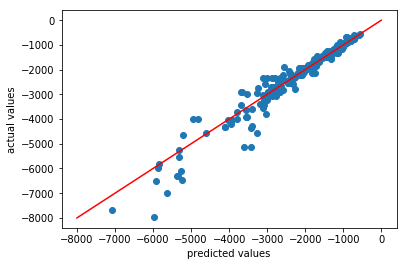

In [7]:
# gridsearch losses with RandomForest

start = time.time()

steps = [('RF', RandomForestRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1,stop=3, num=10)]

criteria = ['mse', 'mae']

depths = [int(n) for n in np.logspace(start=1, stop=2, num=10)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,
            'RF__criterion': criteria,
            'RF__max_depth': depths,
            'RF__max_features': num_features
            }

RF_pipe = Pipeline(steps)

RF_losses_cv = GridSearchCV(RF_pipe, param_grid=RF_params, cv=3)

RF_losses_cv.fit(X_train,losses_train)

end = time.time()



print('Time elapsed: ', end-start)

RF_losses_df = pd.DataFrame(RF_losses_cv.cv_results_)
RF_losses_df.to_csv('BJ_regression/RF_losses_cv_results.csv')
print(RF_losses_cv.best_score_)

RF_losses = RF_losses_cv.best_estimator_
RF_losses.fit(X_train,losses_train)
losses_pred = RF_losses.predict(X_test)
print('R^2: ', r2_score(losses_test,losses_pred))

plt.scatter(losses_pred, losses_test)
plt.plot([-8000,0],[-8000,0], c='r')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

Time elapsed:  47.24548149108887
-8.852839410907133e+17
R^2:  0.7757705076754353


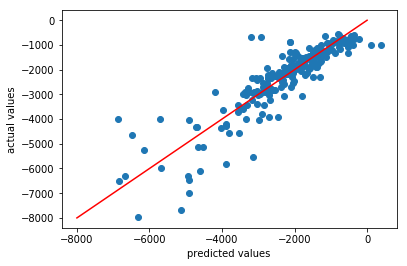

In [8]:
# grid search polynomial regression

start = time.time()

steps = [('poly',PolynomialFeatures()), ('lr', LinearRegression())]

degrees = [1,2,3,4]

polyreg_params = {'poly__degree':degrees}

polyreg_pipe = Pipeline(steps)

polyreg_losses_cv = GridSearchCV(polyreg_pipe, param_grid=polyreg_params, cv=3)

polyreg_losses_cv.fit(X_train,losses_train)

end = time.time()



print('Time elapsed: ', end-start)

polyreg_losses_df = pd.DataFrame(polyreg_losses_cv.cv_results_)
polyreg_losses_df.to_csv('BJ_regression/polyreg_losses_cv_results.csv')
print(polyreg_losses_cv.best_score_)

polyreg_losses = polyreg_losses_cv.best_estimator_
polyreg_losses.fit(X_train,losses_train)
losses_pred = polyreg_losses.predict(X_test)
print('R^2: ', r2_score(losses_test,losses_pred))

plt.scatter(losses_pred, losses_test)
plt.plot([-8000,0],[-8000,0], c='r')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

Time elapsed:  34.289371728897095
0.8374878476255431
R^2:  0.9283814504216321


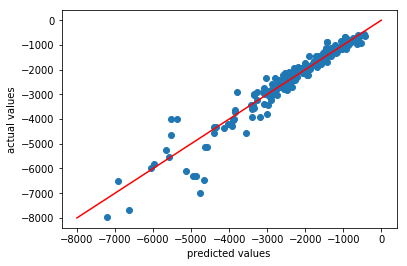

In [9]:
# grid search gradient boosting regressor

start = time.time()

GBR = GradientBoostingRegressor(random_state=2)

lrs = [0.001, 0.01, 0.1, 1]

n_est = [int(n) for n in np.logspace(start=1,stop=3, num=10)]



GBR_params = {'learning_rate':lrs, 'n_estimators':n_est}

GBR_losses_cv = GridSearchCV(GBR, param_grid=GBR_params, cv=3)

GBR_losses_cv.fit(X_train,losses_train)

end = time.time()



print('Time elapsed: ', end-start)

GBR_losses_df = pd.DataFrame(GBR_losses_cv.cv_results_)
GBR_losses_df.to_csv('BJ_regression/GBR_losses_cv_results.csv')
print(GBR_losses_cv.best_score_)

GBR_losses = GBR_losses_cv.best_estimator_
GBR_losses.fit(X_train,losses_train)
losses_pred = GBR_losses.predict(X_test)
print('R^2: ', r2_score(losses_test,losses_pred))

plt.scatter(losses_pred, losses_test)
plt.plot([-8000,0],[-8000,0], c='r')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

Time elapsed:  82.6830370426178
0.7133838254073369
R^2:  0.800160927124138


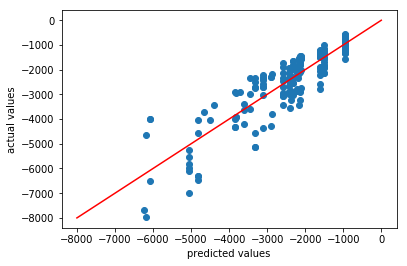

In [10]:
# grid search adaboostregressor

start = time.time()

ada = AdaBoostRegressor(random_state=2)

lrs = [0.001, 0.01, 0.1, 1]

n_est = [int(n) for n in np.logspace(start=1,stop=3, num=10)]



ada_params = {'learning_rate':lrs, 'n_estimators':n_est}

ada_losses_cv = GridSearchCV(ada, param_grid=ada_params, cv=3)

ada_losses_cv.fit(X_train,losses_train)

end = time.time()



print('Time elapsed: ', end-start)

ada_losses_df = pd.DataFrame(ada_losses_cv.cv_results_)
ada_losses_df.to_csv('BJ_regression/ada_losses_cv_results.csv')
print(ada_losses_cv.best_score_)

ada_losses = ada_losses_cv.best_estimator_
ada_losses.fit(X_train,losses_train)
losses_pred = ada_losses.predict(X_test)
print('R^2: ', r2_score(losses_test,losses_pred))

plt.scatter(losses_pred, losses_test)
plt.plot([-8000,0],[-8000,0], c='r')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()